In [1]:
import os, argparse, re
import pandas as pd
import numpy as np
from read_google_sheet import read_google_sheet
from write_google_sheet import write_google_sheet
from get_game_info import get_game_info, get_df_game_record, parse_game_info
from datetime import date
from pprint import pprint
# import plotnine as p9

In [1]:
from add_game_record import add_game_record
add_game_record('current_game.txt')

Local game record not found. Pulling from Google spreadsheet...
597 rows retrieved.
Successfully updated 8 rows and 23 columns of data in Sheet1!A1:W597


In [12]:
import os
import pickle
from googleapiclient import discovery
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

creds = None
# The file token.pickle stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)

service = discovery.build('sheets', 'v4', credentials=creds)

In [13]:
game_info_dict = get_game_info('current_game.txt')
data_in_columns = [game_info_dict[key] for key in game_info_dict.keys()]

# spreadsheet_id = '1DkYahCdFH2EUNKBJJ-6zt55bdj4xgLeKZ-9visw6GrQ' # test
# sheet_id = 2015413252 # test spreadsheet Sheet 2
# range_ = 'Sheet2'
spreadsheet_id = '1So3PBr9gV3I0LzApZOgJlQew2QjM1wAiWhR50rAnHRg' # actual record
sheet_id = 2137801449 # actual record
range_ = 'Sheet1'

# How the input data should be interpreted.
value_input_option = 'RAW'

# How the input data should be inserted.
insert_data_option = 'INSERT_ROWS'

value_range_body = {
    # Add desired entries to the request body.
    'range': range_,
    'majorDimension': 'COLUMNS',
    "values": data_in_columns
}

request = service.spreadsheets().values().append(spreadsheetId=spreadsheet_id, range=range_,
                                                 valueInputOption=value_input_option,
                                                 insertDataOption=insert_data_option,
                                                 body=value_range_body)
response = request.execute()

pprint(response)
# print('Successfully updated', response['updates']['updatedRows'], 'rows and')
# print(response['updates']['updatedColumns'], 'columns of data in', response['tableRange'])

{'spreadsheetId': '1So3PBr9gV3I0LzApZOgJlQew2QjM1wAiWhR50rAnHRg',
 'tableRange': 'Sheet1!A1:W597',
 'updates': {'spreadsheetId': '1So3PBr9gV3I0LzApZOgJlQew2QjM1wAiWhR50rAnHRg',
             'updatedCells': 184,
             'updatedColumns': 23,
             'updatedRange': 'Sheet1!A598:W605',
             'updatedRows': 8}}


In [4]:
def get_index(s):
    '''
    Convert a string of letter notation to number index.
    e.g. 'A' -> 1, 'Z' -> 26, 'AA' -> 27, 'AZ' -> 52
    
    '''
    idx = 0
    for i in range(len(s)):
        temp = ord( s[-(i+1)].lower() ) - 96
        idx += temp * ( 26**i )
        
    return idx

In [8]:
import re
# upper_left = 'A100'
updatedRange = response['updates']['updatedRange']
# Upper left and lower right cells
upper_left = updatedRange.split('!')[1].split(':')[0]
lower_right = updatedRange.split('!')[1].split(':')[1]

col_start = get_index(re.findall(r'[A-Z]+', upper_left)[0]) # 1-based, included
col_end = get_index(re.findall(r'[A-Z]+', lower_right)[0]) # 1-based, included
row_start = int(re.findall(r'[0-9]+', upper_left)[0]) # 1-based, included
row_end = int(re.findall(r'[0-9]+', lower_right)[0]) # 1-based, included
print(row_start)
print(row_end)

9
16


In [9]:
game_id = 89
spreadsheet_id = '1DkYahCdFH2EUNKBJJ-6zt55bdj4xgLeKZ-9visw6GrQ'
sheet_id = 2015413252
highlight_game_id(89, service, spreadsheet_id, sheet_id)
highlight_win(service, spreadsheet_id, sheet_id, col_start, col_end, row_start, row_end)
highlight_lose(service, spreadsheet_id, sheet_id, col_start, col_end, row_start, row_end)
highlight_Yes(service, spreadsheet_id, sheet_id, col_start, col_end, row_start, row_end)
highlight_No(service, spreadsheet_id, sheet_id, col_start, col_end, row_start, row_end)

{'spreadsheetId': '1DkYahCdFH2EUNKBJJ-6zt55bdj4xgLeKZ-9visw6GrQ',
 'replies': [{}]}

In [5]:
# Utility functions
def get_player_stats(df, player, shortstaffed_games_list):
    '''Calculate playing statistics of the specified player
    '''
    assert 'player_id' in df.columns
    assert 'player_win_lose' in df.columns
    assert 'level_up' in df.columns
    assert 'is_dealer' in df.columns
    assert player in df.player_id.to_list()
    
    # subset rows of the specified player
    df_player = df[df.player_id == player]
    
    # cumulative levels up
    lifetime_level = df_player.lifetime_level_after.max()
    
    # subset rows that this player wins
    df_player_winning = df_player[df_player.player_win_lose == 'win']
    
    # calculate the winning rate
    winning_rate = len(df_player_winning) / len(df_player)
    
    # calculate the average levels up per winning game
    if len(df_player_winning) > 0:
        average_level_up = df_player_winning.level_up.mean()
    else:
        average_level_up = 0
    
    # subset rows that this player is dealer
    df_player_dealing = df_player[df_player.is_dealer == 'Yes']
        
    # subset rows that this player is dealer and wins
    df_player_dealing_winning = df_player[(df_player.is_dealer == 'Yes') &
                                          (df_player.player_win_lose == 'win')]
    
    # calculate the winning rate as dealer
    if len(df_player_dealing) > 0:
        winning_rate_as_dealer = len(df_player_dealing_winning) / len(df_player_dealing)
    else:
        winning_rate_as_dealer = 0
    
    # calculate the number of occurrences of shortstaffed dealer team as dealer
    dealing_games_list = df_player_dealing.game_id.tolist()
    n_shortstaffed_games = len( list(set(shortstaffed_games_list) & set(dealing_games_list)) )
    
    # subset rows that player is MVP
    df_player_MVP = df_player[df_player.is_MVP == 'Yes']
    
#     player_stats = [player,
#                     lifetime_level,
#                     winning_rate,
#                     average_level_up,
#                     len(df_player),
#                     len(df_player_MVP),
#                     len(df_player_dealing),
#                     n_shortstaffed_games,
#                     winning_rate_as_dealer]

    # formatted version
    player_stats = [player.replace('_', ' <br> '),
                    lifetime_level,
                    "{:.1%}".format(winning_rate),
                    "{:.2f}".format(average_level_up),
                    len(df_player),
                    len(df_player_MVP),
                    len(df_player_dealing),
                    n_shortstaffed_games,
                    "{:.1%}".format(winning_rate_as_dealer)]
    
    return player_stats

def get_dealer_winning_rate_at_n_decks(df, n_decks):
    '''calculate the dealer's winning rate of the specified n_decks
    '''
    assert 'n_decks' in df.columns
    assert 'dealer_win_lose' in df.columns
    assert 'game_id' in df.columns
    
    df_n_decks = df[df.n_decks == n_decks]
    if len(df_n_decks) > 0:
        df_selected = df[(df.n_decks == n_decks) & (df.dealer_win_lose == 'win')]
        winning_rate = df_selected.game_id.nunique() / df_n_decks.game_id.nunique()
        return winning_rate
    else:
        return 'na'

def get_dealer_winning_rate_at_n_players(df, n_players):
    '''calculate the dealer's winning rate of the specified n_players
    '''
    assert 'n_players' in df.columns
    assert 'dealer_win_lose' in df.columns
    assert 'game_id' in df.columns
    
    df_n_decks = df[df.n_players == n_players]
    if len(df_n_decks) > 0:
        df_selected = df[(df.n_decks == n_decks) & (df.dealer_win_lose == 'win')]
        winning_rate = df_selected.game_id.nunique() / df_n_decks.game_id.nunique()
        return winning_rate
    else:
        return 'na'
    
def dealer_team_shortstaffed(df, game_id):
    '''determine whether the dealer team has fewer members than expected
    '''
    assert 'game_id' in df.columns
    assert 'n_players' in df.columns
    assert 'on_dealer_team' in df.columns
    
    df_current_game = df[df.game_id == game_id]
    df_current_game.reset_index(inplace=True)
    n_players = df_current_game.n_players[0]
    expected_dealer_team_n = (n_players-n_players%2)/2
    actual_dealer_team_n = df_current_game.groupby('on_dealer_team').describe().loc['Yes','game_id']['count']
    
    return actual_dealer_team_n < expected_dealer_team_n

def get_games_dealer_team_shortstaffed(df):
    '''get a list of game_id when the dealer team is shortstaffed
    '''
    assert 'game_id' in df.columns
    assert 'n_players' in df.columns
    assert 'on_dealer_team' in df.columns
    
    games_dealer_team_shortstaffed = []
    for game_id in df.game_id.unique():
        if dealer_team_shortstaffed(df, game_id):
            games_dealer_team_shortstaffed.append(game_id)
    
    return games_dealer_team_shortstaffed

In [6]:
df_columns = ['game_id', 'player_id', 'is_dealer', 'on_dealer_team',
       'player_win_lose', 'is_MVP', 'level_before', 'level_rounds_before',
       'level_after', 'level_rounds_after', 'prime_suit', 'n_players',
       'n_decks', 'score_goal', 'score', 'dealer_win_lose',
       'non_dealer_win_lose', 'level_up', 'lifetime_level_before',
       'lifetime_level_after', 'year', 'month', 'day', 'date']

In [11]:
df_player_history = df[['player_id', 'lifetime_level_before']]
df_player_history.sort_values(by=['player_id', 'lifetime_level_before'], ascending=True, inplace=True)

player_reformatted = [player.replace('_', ' ') for player in df_player_history.player_id]
df_player_history.loc[:, 'player_id'] = player_reformatted

# make game inex
game_index = []
for i in df_player_history.groupby('player_id').describe()['lifetime_level_before']['count']:
    for j in range(int(i)):
        game_index.append(j)
df_player_history['game_index'] = game_index
df_player_history


<ipython-input-11-2b9089b7e28e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/wangs20/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-11-2b9089b7e28e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,player_id,lifetime_level_before,game_index
1,Di Wu,0,0
7,Di Wu,0,1
13,Di Wu,2,2
19,Di Wu,3,3
25,Di Wu,3,4
...,...,...,...
417,Zheng Li,68,59
426,Zheng Li,72,60
435,Zheng Li,81,61
444,Zheng Li,83,62


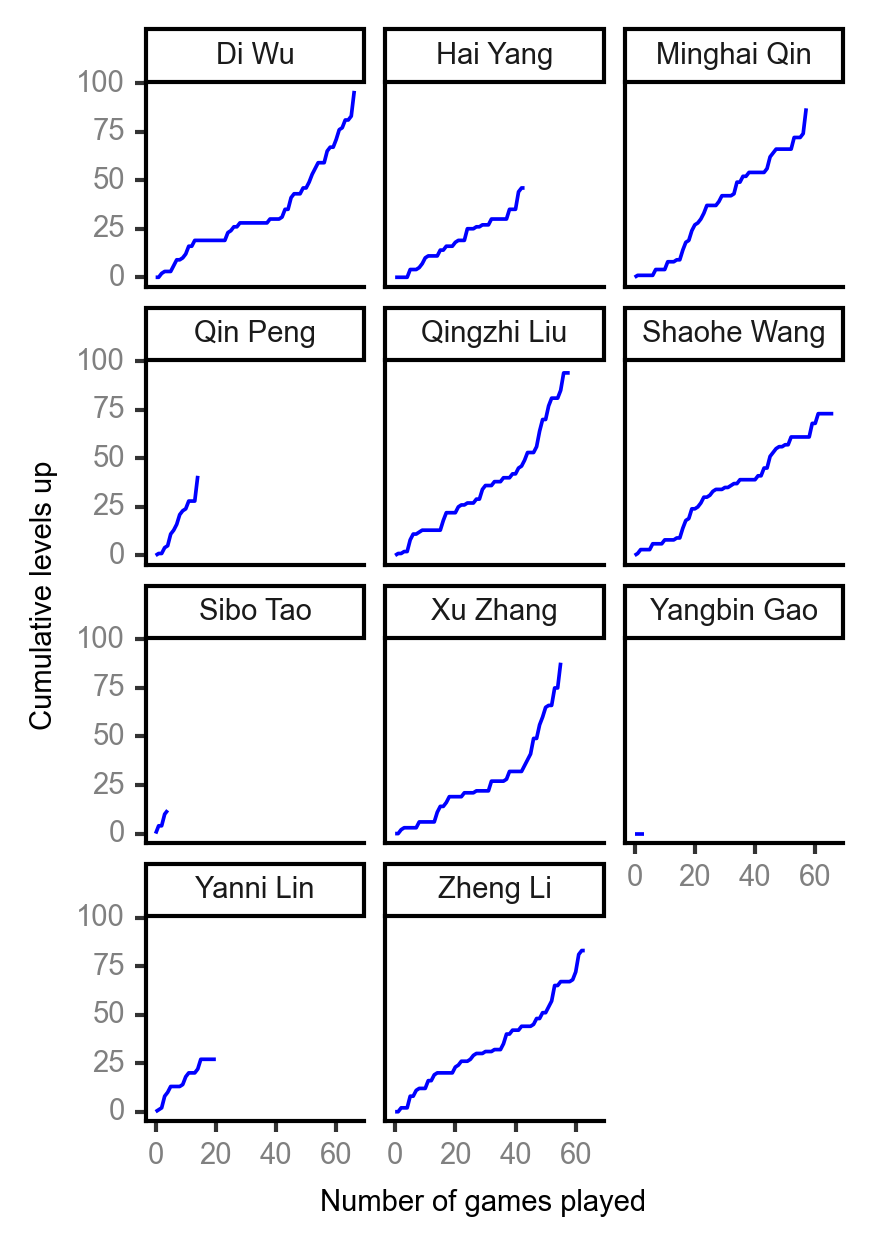

<ggplot: (8787058625154)>

In [33]:
# plot with plotnine
player_history_plot = (
p9.ggplot(data=df_player_history,
          mapping=p9.aes(x='game_index',
                         y='lifetime_level_before'))
#     + p9.geom_point(alpha=0.1)
    + p9.geom_line(color='blue')
    + p9.xlab("Number of games played")
    + p9.ylab("Cumulative levels up")
    + p9.theme_classic() # use alternative themes
    + p9.facet_wrap("player_id", ncol=3)
    + p9.theme(axis_text_x = p9.element_text(color="grey", size=7, family='Arial'),
               axis_text_y = p9.element_text(color="grey", size=7, family='Arial'))
#     + p9.theme(p9.element_rect({'alpha': 0}))
    + p9.theme(figure_size=(3, 4.5), dpi=300)
    + p9.theme(text=p9.element_text(size=7, family='Arial'))
)
player_history_plot
# player_history_plot.save('../snownontrace.github.io/assets/images/player_history_plot.png')

In [6]:
# get a list of game_id when the dealer team is shortstaffed
shortstaffed_games_list = get_games_dealer_team_shortstaffed(df)

In [9]:
player_stats_data = []
for player in df.player_id.unique():
    player_stats_data.append(get_player_stats(df, player, shortstaffed_games_list))
player_stats_df = pd.DataFrame(player_stats_data,
                               columns=['Player',
                                        'Lifetime levels up',
                                        'Winning rate',
                                        'Average levels up',
                                        'N_games played',
                                        'N_games as MVP',
                                        'N_games as dealer',
                                        'N_games short staffed as dealer',
                                        'Winning rate as dealer'])

player_stats_df.sort_values(by=['Lifetime levels up', 'Winning rate', 'Average levels up'], 
                            ascending=False, inplace=True)
player_stats_df.reset_index(inplace=True, drop=True)
player_stats_df['Rank'] = list(range(1, len(player_stats_df)+1))
player_stats_df = player_stats_df[['Rank'] + player_stats_df.columns[:-1].tolist()]
player_stats_df

,Rank,Player,Lifetime levels up,Winning rate,Average levels up,N_games played,N_games as MVP,N_games as dealer,N_games short staffed as dealer,Winning rate as dealer
0,1,Minghai <br> Qin,72,52.8%,2.57,53,0,7,1,57.1%
1,2,Qingzhi <br> Liu,70,57.1%,2.50,49,0,8,2,62.5%
2,3,Zheng <br> Li,65,51.9%,2.32,54,0,9,0,44.4%
3,4,Di <br> Wu,65,43.9%,2.60,57,1,6,0,50.0%
4,5,Shaohe <br> Wang,61,52.6%,2.03,57,0,12,1,33.3%
5,6,Xu <br> Zhang,49,36.2%,2.88,47,0,6,0,16.7%
6,7,Hai <br> Yang,30,41.2%,2.14,34,1,5,1,20.0%
7,8,Qin <br> Peng,23,88.9%,2.88,9,0,2,0,100.0%
8,9,Yanni <br> Lin,22,64.3%,2.44,14,0,2,1,100.0%
9,10,Sibo <br> Tao,14,80.0%,3.50,5,0,0,0,0.0%


In [12]:
# update the markdown file in the gibhub pages folder
header_file = open('../snownontrace.github.io/player_stats_header.md', 'r') 
lines = header_file.readlines()

# get today's date
today = date.today()
date_today = today.strftime("%Y-%m-%d")

with open('../snownontrace.github.io/player_stats.md', 'w') as the_file:
    for line in lines[:5]:
        the_file.write(line)
    # update the date with the current date
    the_file.write('date: ' + date_today + '\n')
    for line in lines[6:12]:
        the_file.write(line)
    for i in range(len(player_stats_df)):
        player_stats = [str(iii) for iii in player_stats_df.iloc[i,:].tolist()]
        player_stats_line = '| ' + ' | '.join(player_stats) + ' |' + '\n'
        the_file.write(player_stats_line)
    for line in lines[-4:]:
        the_file.write(line)

In [88]:
header_file = open('../snownontrace.github.io/player_stats_header.md', 'r') 
lines = header_file.readlines()
lines

['---\n',
 'layout: player_stats\n',
 'title: Player Statistics\n',
 'author: Shaohe Wang\n',
 'author_url: https://scholar.google.com/citations?user=R_-kJV4AAAAJ&hl=en\n',
 'date: 2020-11-30\n',
 '---\n',
 '\n',
 '<div class="table-wrapper" markdown="block">\n',
 '\n',
 '| <br><br><br>Rank | <br><br><br>Player | <br> Lifetime <br> levels <br> up | <br><br> Winning <br> rate | <br> Average <br> levels <br> up | <br> Total <br> games <br> played | Games <br> played <br> as <br> MVP | Games <br> played <br> as <br> dealer | N_games <br> short <br> staffed <br> as dealer | Winning <br> rate <br> as <br> dealer |\n',
 '|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|\n',
 '| 1 | Example | 49 | 88.9% | 2.88 | 9 | 1 | 2 | 0 | 100.0% |\n',
 '\n',
 '</div>\n',
 '\n',
 '<img src="/assets/images/player_history_plot.png" alt="Plot of player level history" />\n']

In [93]:
for line in lines[-4:]:
    print(line)



</div>



<img src="/assets/images/player_history_plot.png" alt="Plot of player level history" />

